We'll start of rendering in bokeh, to show the potential of adding interactive plots.

In [1]:
import numpy as np
from bokeh.io import output_notebook, show
from bokeh.models.glyphs import Circle, Segment
from bokeh.models import ColumnDataSource, Range1d, DataRange1d, Plot
import pandas as pd
from bokeh.models import HoverTool, TapTool, BoxZoomTool, ResetTool, OpenURL
from scipy.cluster.hierarchy import ward
from skbio import TreeNode, DistanceMatrix
from cooltree import UnrootedDendrogram, ShelvedDendrogram, StraightDendrogram, SquareDendrogram
output_notebook()

from builtins import property as _property, tuple as _tuple
from operator import itemgetter as _itemgetter
from collections import OrderedDict

class Dimensions(tuple):
    'Dimensions(x, y, height)'

    __slots__ = ()

    _fields = ('x', 'y', 'height')

    def __new__(_cls, x, y, height):
        'Create new instance of Dimensions(x, y, height)'
        return _tuple.__new__(_cls, (x, y, height))

    @classmethod
    def _make(cls, iterable, new=tuple.__new__, len=len):
        'Make a new Dimensions object from a sequence or iterable'
        result = new(cls, iterable)
        if len(result) != 3:
            raise TypeError('Expected 3 arguments, got %d' % len(result))
        return result

    def _replace(_self, **kwds):
        'Return a new Dimensions object replacing specified fields with new values'
        result = _self._make(map(kwds.pop, ('x', 'y', 'height'), _self))
        if kwds:
            raise ValueError('Got unexpected field names: %r' % list(kwds))
        

Loading BokehJS ...

In [2]:
np.random.seed(0)
num_otus = 500  #otus 
x = np.random.rand(num_otus)
dm = DistanceMatrix.from_iterable(x, lambda x, y: np.abs(x-y))
lm = ward(dm.condensed_form())
t = TreeNode.from_linkage_matrix(lm, np.arange(len(x)).astype(np.str))

In [3]:
t = UnrootedDendrogram.from_tree(t)

In [4]:
for i, n in enumerate(t.postorder(include_self=True)):
    n.length = 1
    if not n.is_tip():
        n.name = "y%d" % i
#t._cache_ntips()

In [5]:
colors = {'r': '#FF0000', 'g': '#00FF00', 'b': '#0000FF'}

In [6]:
pts = t.coords(500, 500)
edges = pts[['child0', 'child1']]
edges = edges.dropna(subset=['child0', 'child1'])
edges = edges.unstack()
edges = pd.DataFrame({'src_node': edges.index.get_level_values(1),
                      'dest_node' : edges.values})
edges['x0'] = [pts.loc[n].x for n in edges.src_node]
edges['x1'] = [pts.loc[n].x for n in edges.dest_node]
edges['y0'] = [pts.loc[n].y for n in edges.src_node]
edges['y1'] = [pts.loc[n].y for n in edges.dest_node]

In [7]:
tips = edges.loc[[pts.loc[n].is_tip for n in edges.dest_node] ]

In [8]:
plot_options = dict(plot_width=800, plot_height=800, toolbar_location=None, 
                    outline_line_color=None)

In [9]:
radius = dict(value=1, units="data")

leaf_glyph = Circle(x="x1", y="y1", 
                    radius=radius, 
                    fill_color="#707070", 
                    name="circles", 
                    fill_alpha=0.5) 

tree_glyph = Segment(x0="x0", y0="y0", 
                     x1="x1", y1="y1", 
                     line_color="#151515",
                     line_alpha=0.75)

tip_glyph = Segment(x0="x0", y0="y0", 
                     x1="x1", y1="y1", 
                     line_color="#FF0000",
                     line_width=1.65)

In [10]:
def df2ds(df):
    return ColumnDataSource(ColumnDataSource.from_df(df))

In [11]:
ydr = DataRange1d(range_padding=0.05)  
xdr = DataRange1d(range_padding=0.05)  

plot = Plot(x_range=xdr, y_range=ydr, **plot_options)
plot.add_glyph(df2ds(edges), tree_glyph)
plot.add_glyph(df2ds(tips), tip_glyph)
plot.add_glyph(df2ds(tips), leaf_glyph)

GlyphRenderer(id='90a145af-c87e-4e24-8ad1-23f6fb84c4af', ...)

In [12]:
show(plot)

Now we'll show how to render in matplotlib

In [13]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [14]:
edges.head()

,dest_node,src_node,x0,x1,y0,y1
0,154,y10,196.005063,176.010164,326.717777,334.537594
1,166,y105,182.704315,172.047472,428.484778,447.122836
2,417,y106,193.243843,182.353634,409.780130,428.282802
3,283,y107,203.900687,192.778832,391.142072,409.506436
4,99,y108,214.674426,203.322682,372.571340,390.794497


In [15]:
n

<UnrootedDendrogram, name: y998, internal node count: 498, tips count: 500>

In [16]:
# for creating horseshoes
def normsquare(x):
    return np.sum([p**2 for p in x])

def distance(x1,x2):
    return np.sqrt(normsquare(x1-x2))

def shift1(l):
    newlist = [0] * len(l)
    for i in range(1,len(l)):
        newlist[i] = l[i-1]
    return newlist

def shift(l,n):
    sl = l
    table = [l]
    if n == 0:
        return table
    else:
        for k in range(n):
            sl = shift1(sl)
            table.append(sl)
        return table

def join(point1,point2):
    x0, y0 = point1
    x1, y1 = point2
    line_ans = lambda x: x* (y1-y0) / (x1-x0) + (y1 - y0) 
band = 30 #band size
p = num_otus - band + 1 #samples
y = [1./band]*band + [0]*(num_otus-band)
table = shift(y,p-1)
table = np.column_stack(table)    

In [17]:
table.shape

(500, 471)

In [18]:
t = SquareDendrogram.from_tree(t)
pts = t.coords(width=20, height=table.shape[0])
edges = pts[['child0', 'child1']]
edges = edges.dropna(subset=['child0', 'child1'])
edges = edges.unstack()
edges = pd.DataFrame({'src_node': edges.index.get_level_values(1),
                      'dest_node' : edges.values})
edges['x0'] = [pts.loc[n].x for n in edges.src_node]
edges['x1'] = [pts.loc[n].x for n in edges.dest_node]
edges['y0'] = [pts.loc[n].y for n in edges.src_node]
edges['y1'] = [pts.loc[n].y for n in edges.dest_node]

<IPython.core.display.Javascript object>


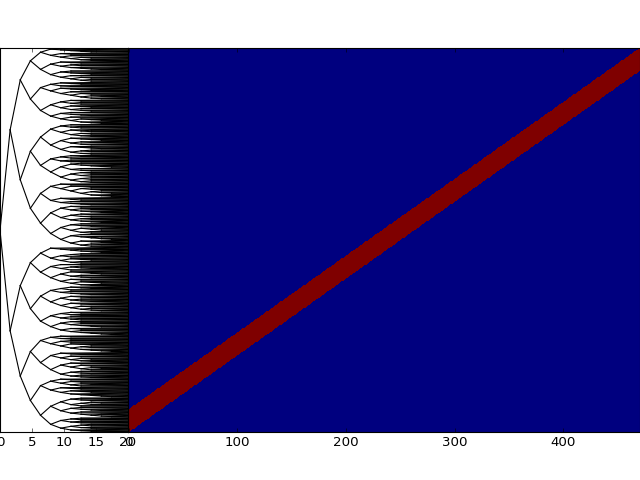

[]

In [19]:
xwidth=0.2

fig = plt.figure()
# heatmap axes
[axm_x, axm_y, axm_w, axm_h] = [0, 0.1, xwidth, 0.8]
# dendrogram axes on the right side
[ax1_x, ax1_y, ax1_w, ax1_h] = [xwidth, 0.1, 1-xwidth, 0.8]



ax1 = fig.add_axes([ax1_x, ax1_y, ax1_w, ax1_h], frame_on=True)
ax1.imshow(table, aspect='auto', interpolation='nearest')

axm = fig.add_axes([axm_x, axm_y, axm_w, axm_h], frame_on=True, sharey=ax1)
for i in range(len(edges.index)):
    row = edges.iloc[i]
    axm.plot([row.x0, row.x1], [row.y0, row.y1], '-k')
axm.set_ylim([0, table.shape[0]])
axm.set_yticks([])    